# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 5 steps, each in a single notebook:
1. **Get probe template**
2. Get the Bragg disks
3. Calculate lattice vectors
4. Calculate strain
5. Visualize strain maps

# Notebook 1: Get probe template

The aim here is to create a convolution kernel in the shape of the unscattered electron beam, which can then be used to identify the Bragg disks in each diffraction pattern of the datacube.  

Possible approaches include:
1. Use a scan region of the 4DSTEM datacube that was over vacuum (or perhaps thin amorphous support)
2. Use a separate 4DSTEM datacube take over vacuum
3. Create an artificial probe

Here, we demonstrate approach 1, proceeding as follows:

* Get average vacuum probe
    * Select an ROI over (nearly) vacuum
    * Find shifts of DPs within ROI relative to one reference DP
    * Register and average all DPs in ROI
* Create vacuum probe kernel
    * Mask probe outside of central disk
    * Get probe CoM and size
    * Normalize probe to integrate to 1
    * Subtract normalized 2D gaussian to get kernel integrating to 0
    * Center kernel in Fourier space (i.e. at corners of array)
* Save the vacuum probe kernel

### Import packages, load data

In [12]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_dilation as binary_dilation

from py4DSTEM.process.datastructure import DiffractionSlice, RealSlice

In [2]:
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3 is not a py4DSTEM file.  Reading with hyperspy...


In [3]:
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

### Get the average vacuum probe

In [4]:
# ROI

xmin,xmax=45,55
ymin,ymax=5,15

data = np.zeros_like(dc.data4D[:,:,0,0],dtype=bool)
data[xmin:xmax,ymin:ymax] = True

ROI = RealSlice(data,dc)

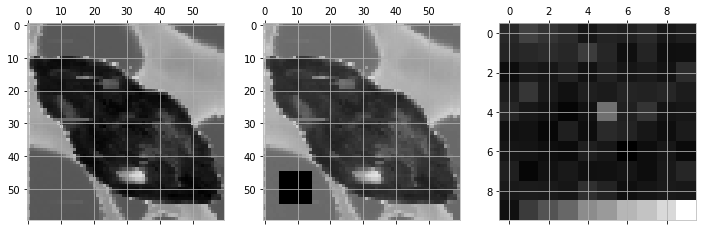

In [5]:
ave_im = np.average(dc.data4D,axis=(2,3))

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(ave_im,cmap='gray')
ax2.matshow(ave_im*(ROI.data2D==False),cmap='gray')
ax3.matshow(ave_im[ROI.data2D].reshape(xmax-xmin,ymax-ymin),cmap='gray')
plt.show()

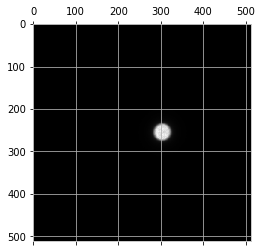

In [6]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[ROI.data2D,:,:],axis=(0))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [7]:
# Get average shift-corrected diffraction pattern

length = ROI.data2D.sum()
ref_DP = dc.data4D[ROI.data2D,:,:][0]

for n in range(1,length):
    curr_DP = dc.data4D[ROI.data2D,:,:][n]
    
    xshift,yshift = py4DSTEM.process.utils.get_shift(ref_DP, curr_DP)
    curr_DP_shifted = py4DSTEM.process.utils.get_shifted_ar(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

probe_template = DiffractionSlice(ref_DP,dc)

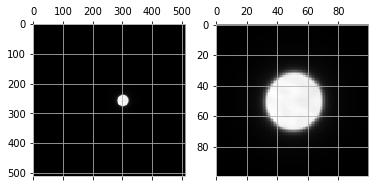

In [8]:
# Get (initial) center of mass
# Show shifted, averaged DP

xCoM_init,yCoM_init = py4DSTEM.process.utils.get_CoM(probe_template.data2D)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template.data2D,cmap='gray')
ax2.matshow(probe_template.data2D[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
plt.show()

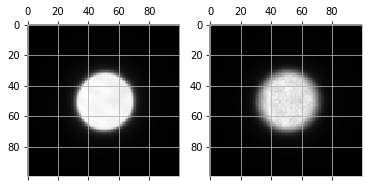

In [9]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = py4DSTEM.process.utils.get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template.data2D[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
ax2.matshow(DP_ave_unshifted[int(xCoM_unshifted)-50:int(xCoM_unshifted)+50,int(yCoM_unshifted)-50:int(yCoM_unshifted)+50])
plt.show()

### Create vacuum probe kernel

In [13]:
# Mask probe outside of central disk

mask_thresh = 0.2
mask_expansion = 12

mask = ref_DP > np.max(probe_template.data2D)*mask_thresh
mask = binary_dilation(mask,iterations=mask_expansion)

#maskDist = 0.5 + 0.5*erf(maskShift + (bwdist(~maskRound) - bwdist(bwmorph(maskRound,'dilate',1))) / (0.5*maskWidth));

probe_template.data2D = probe_template.data2D*mask

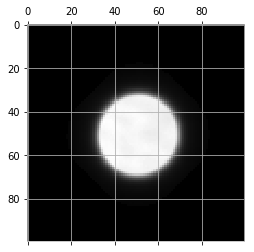

Mask alters CoM by 0.31366024761400885 pixels.


In [14]:
# Get CoM
# Compare to CoM without mask

xCoM,yCoM = py4DSTEM.process.utils.get_CoM(probe_template.data2D)

fig,ax=plt.subplots()
ax.matshow(probe_template.data2D[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
plt.show()

print("Mask alters CoM by {} pixels.".format(np.sqrt((yCoM-yCoM_init)**2+(xCoM-xCoM_init)**2)))

In [15]:
# Get probe size

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
q2 = (qx-xCoM)**2 + (qy-yCoM)**2
qstd2 = np.sum(q2*probe_template.data2D*mask) / np.sum(probe_template.data2D)

In [16]:
# Normalize probe to one
# Subtract off gaussian, to yield a kernel which integrates to zero
sigma_probe_scale = 5

probe_template_norm = probe_template.data2D/np.sum(probe_template.data2D)
subtr_gaussian = np.exp(-q2 / (2*qstd2*sigma_probe_scale**2))
subtr_gaussian = subtr_gaussian/np.sum(subtr_gaussian)
probe_kernel = probe_template_norm - subtr_gaussian

probe_kernel = py4DSTEM.process.datastructure.DiffractionSlice(probe_kernel, dc, name='probe_kernel')

print("Probe kernel sums to {}.".format(np.sum(probe_kernel.data2D)))

Probe kernel sums to -1.4100049253173985e-16.


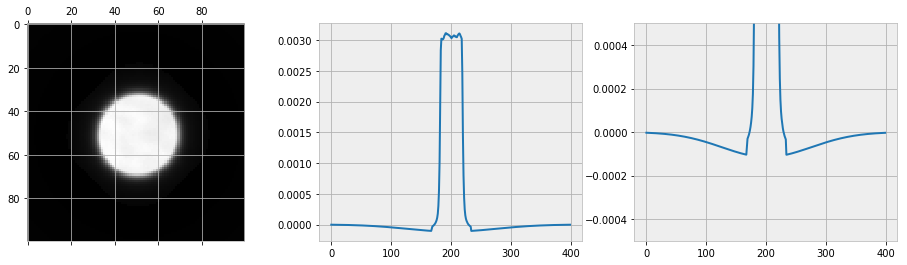

In [17]:
# Plot line profile through probe_kernel

#xCoM,yCoM = py4DSTEM.process.utils.get_CoM(probe_template.data2D)
rad=200
width=2

line_profile = np.sum(probe_kernel.data2D[int(xCoM)-rad:int(xCoM)+rad,int(yCoM)-width:int(yCoM)+width],axis=(1))

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.matshow(probe_kernel.data2D[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
ax2.plot(np.arange(len(line_profile)),line_profile)
ax3.plot(np.arange(len(line_profile)),line_profile)
ax3.set_ylim(-0.0005,0.0005)
plt.show()

In [18]:
# Shift probe kernel to center, then to corners
probe_kernel.data2D = py4DSTEM.process.utils.get_shifted_ar(probe_kernel.data2D,-xCoM,-yCoM)

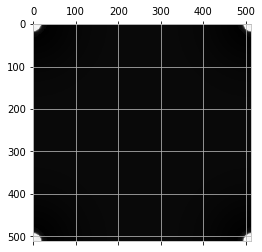

In [19]:
fig,ax=plt.subplots()
ax.matshow(probe_kernel.data2D,cmap='gray')
plt.show()

### Save the vacuum probe kernel

In [20]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
py4DSTEM.readwrite.save_dataobject(probe_kernel,savepath)

Creating file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5...
Writing metadata...
Done.


## 2. Get the diffraction shifts

In this step the relative shift of each diffraction pattern is determined, as follows:

* For one diffraction pattern, get the Bragg disk positions of unscattered beam.
    * Convolve with the probe kernel
    * Get the positions and strengths of all bragg disks by identifying local maxima
* For all DPs, get the positions of unscattered beam.
    * Loop over all DPs, get all Bragg disk positions
    * Get the average deconvolution
    * Get average central beam position, from brightest peak of average deconvolution
    * Get the central beam for each DP, as closest peak to average central beam position
* Fit diffraction shifts
    * Fit plane or 2d parabaloid to unscattered beam positions

### 2a. Single diffraction pattern

* For one diffraction pattern, get the Bragg disk positions of unscattered beam.
    * Convolve with the probe kernel
    * Get the positions and strengths of all bragg disks by identifying local maxima

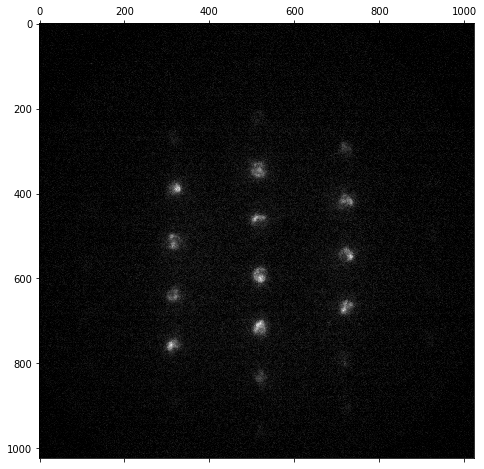

In [51]:
# Pick a test diffraction pattern
Ri,Rj = 25,50
DP = dc.data4D[Ri,Rj,:,:]

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(DP)
plt.show()

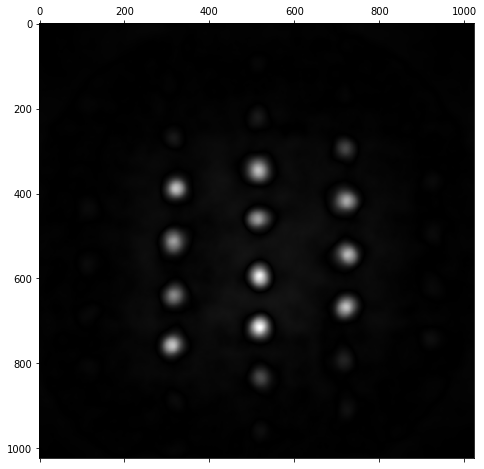

In [52]:
# Cross correlation

corrPower = 1  # Correlation type, in [0,1]. 0=phase correlation, 1=cross correlation

cc = py4DSTEM.process.utils.get_cross_correlation(DP,probe_kernel.data2D,corrPower)

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(np.abs(cc))
plt.show()

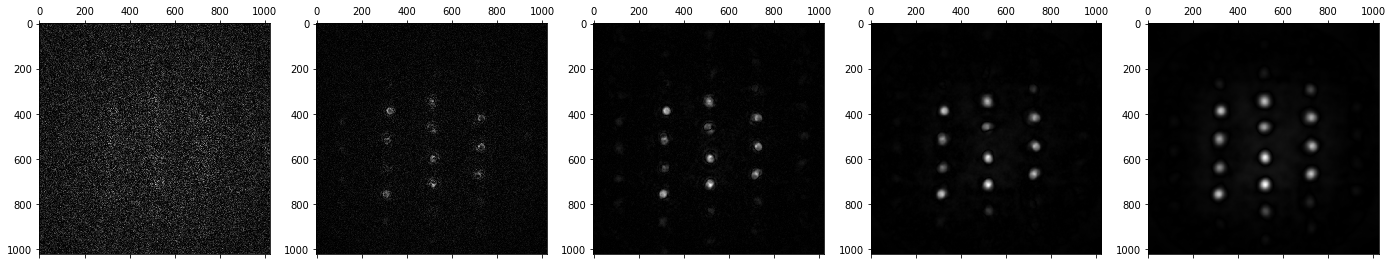

In [53]:
# Test different hybrid correlations

ccs = []
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for corrPower in np.linspace(0,1,5):
    cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)
    ccs.append(cc)

fig,axs = plt.subplots(1,5,figsize=(24,48))
for i in range(len(ccs)):
    axs[i].matshow(np.abs(ccs[i]))
plt.show()

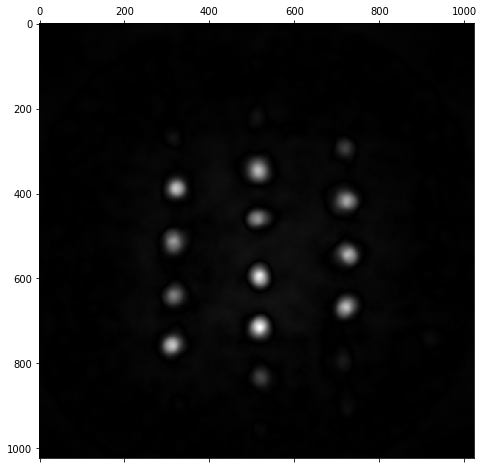

In [54]:
# Select hybrid correlation coefficient

corrPower = 0.9  # Correlation type, in [0,1]. 0=phase correlation, 1=cross correlation

cc = py4DSTEM.process.utils.get_cross_correlation(DP,probe_kernel.data2D,corrPower)

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(np.abs(cc))
plt.show()

In [55]:
# Apply small gaussian smoothing filter

sigma_gaussianFilter = 2

cc = np.maximum(cc,0)
cc = gaussian_filter(cc, sigma_gaussianFilter)

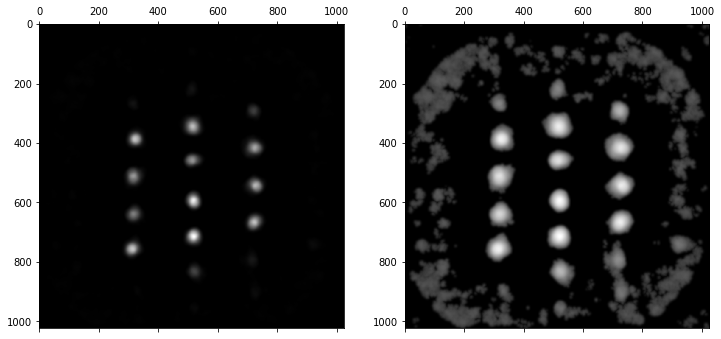

In [56]:
# Show cross correlation and log(cc)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(np.maximum(cc,0)**0.25)
plt.show()

In [57]:
# Get maximal points

max_points = py4DSTEM.process.utils.get_maximal_points(cc)

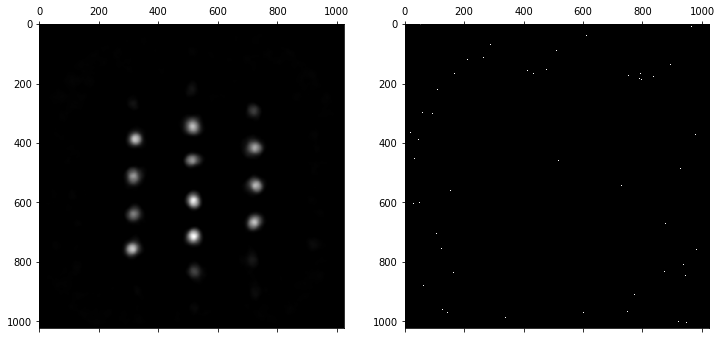

In [58]:
# Show max_points with cross correlation

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(max_points)
plt.show()

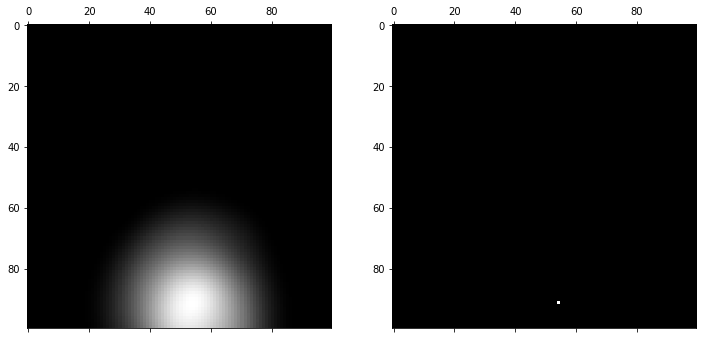

In [59]:
# Zoom in

xc,yc = py4DSTEM.process.utils.get_CoM(cc)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc[int(xc)-50:int(xc)+50,int(yc)-50:int(yc)+50])
ax2.matshow(max_points[int(xc)-50:int(xc)+50,int(yc)-50:int(yc)+50])
plt.show()

In [60]:
edge_boundary = 20

max_points[:edge_boundary,:]=False
max_points[-edge_boundary:,:]=False
max_points[:,:edge_boundary]=False
max_points[:,-edge_boundary:]=False    

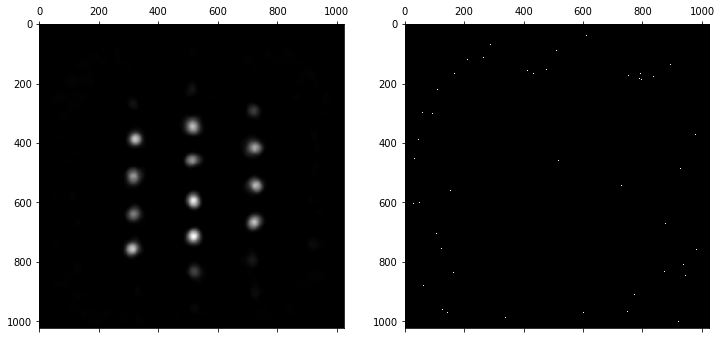

In [61]:
# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(max_points)
plt.show()

In [62]:
# Make point_list with structured array datatype

coords = [('rx',float),('ry',float),('qx',float),('qy',float),('intensity',float)]
point_list = PointList(coordinates=coords, parentDataCube=dc)

max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
point_intensities = cc[max_point_indices_x,max_point_indices_y]

length = len(point_intensities)
for i in range(length):
    new_point = (Ri,Rj,max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
    point_list.add_point(new_point)

In [63]:
# Order point list, keep only up to maxNumPeaks

maxNumPeaks = 45

numPeaks = min(maxNumPeaks,length)
point_list.sort(coordinate='intensity',order='descending')
point_list.data = point_list.data[:numPeaks]

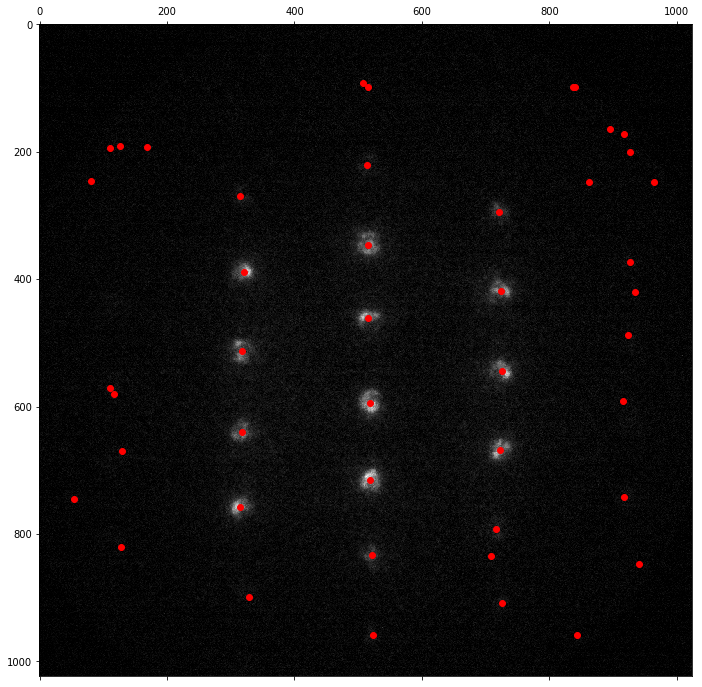

In [64]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(DP)
ax.scatter(point_list.data['qy'],point_list.data['qx'],color='r')
plt.show()

In [65]:
# Remove peaks that are too close together

minPeakSpacing = 32

r2 = minPeakSpacing**2
deletePeaks = np.zeros(numPeaks,dtype=bool)
for i in range(numPeaks):
    if deletePeaks[i] == False:
        tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                  (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
        tooClose[:i+1] = False
        deletePeaks[tooClose] = True
point_list.remove_points(deletePeaks)

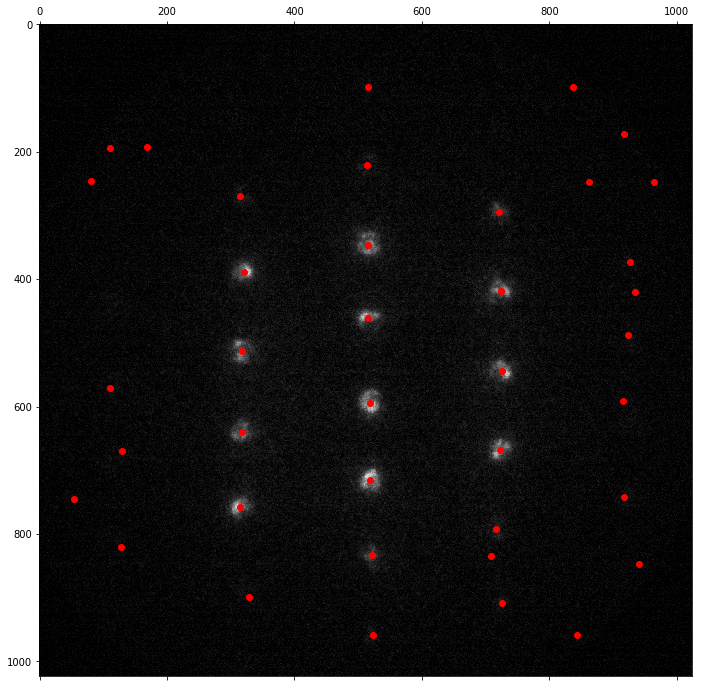

In [66]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(DP)
ax.scatter(point_list.data['qy'],point_list.data['qx'],color='r')
plt.show()

### 2b. Get diffraction shifts for all DPs

* For all DPs, get the positions of unscattered beam.
    * Loop over all DPs, get all Bragg disk positions
    * Get the average deconvolution
    * Get average central beam position, from brightest peak of average deconvolution
    * Get the central beam for each DP, using closest peak to average central beam position

In [67]:
# Loop over all DP's, getting all Bragg disk positions

corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 45
minPeakSpacing = 32

coords = [('rx',float),('ry',float),('qx',float),('qy',float),('intensity',float)]
Bragg_peak_point_list = PointList(coordinates=coords, parentDataCube=dc)

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Ri,Rj))

        # Get diffraction pattern
        DP = dc.data4D[Ri,Rj,:,:]
        
        # Cross correlation     
        cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = py4DSTEM.process.utils.get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
        point_list = PointList(coordinates=coords, parentDataCube=dc, save_behavior=False)

        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        length = len(point_intensities)
        for i in range(length):
            new_point = (Ri,Rj,max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
            point_list.add_point(new_point)
        
        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,length)
        point_list.sort(coordinate='intensity',order='descending')
        point_list.data = point_list.data[:numPeaks]        
        
        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
    
        # Add current point list to running list
        Bragg_peak_point_list.add_pointlist(point_list)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 5,35
Analyzing scan position 5,36
Analyzing scan position 5,37
Analyzing scan position 5,38
Analyzing scan position 5,39
Analyzing scan position 5,40
Analyzing scan position 5,41
Analyzing scan position 5,42
Analyzing scan position 5,43
Analyzing scan position 5,44
Analyzing scan position 5,45
Analyzing scan position 5,46
Analyzing scan position 5,47
Analyzing scan position 5,48
Analyzing scan position 5,49
Analyzing scan position 6,0
Analyzing scan position 6,1
Analyzing scan position 6,2
Analyzing scan position 6,3
Analyzing scan position 6,4
Analyzing scan position 6,5
Analyzing scan position 6,6
Analyzing scan position 6,7
Analyzing scan position 6,8
Analyzing scan position 6,9
Analyzing scan position 6,10
Analyzing scan position 6,11
Analyzing scan position 6,12
Analyzing scan position 6,13
Analyzing scan position 6,14
Analyzing scan position 6,15
Analyzing scan position 6,16
Analyzing scan position 6,17
Analyzing scan position 6,18
Analyzing scan position 

Analyzing scan position 11,18
Analyzing scan position 11,19
Analyzing scan position 11,20
Analyzing scan position 11,21
Analyzing scan position 11,22
Analyzing scan position 11,23
Analyzing scan position 11,24
Analyzing scan position 11,25
Analyzing scan position 11,26
Analyzing scan position 11,27
Analyzing scan position 11,28
Analyzing scan position 11,29
Analyzing scan position 11,30
Analyzing scan position 11,31
Analyzing scan position 11,32
Analyzing scan position 11,33
Analyzing scan position 11,34
Analyzing scan position 11,35
Analyzing scan position 11,36
Analyzing scan position 11,37
Analyzing scan position 11,38
Analyzing scan position 11,39
Analyzing scan position 11,40
Analyzing scan position 11,41
Analyzing scan position 11,42
Analyzing scan position 11,43
Analyzing scan position 11,44
Analyzing scan position 11,45
Analyzing scan position 11,46
Analyzing scan position 11,47
Analyzing scan position 11,48
Analyzing scan position 11,49
Analyzing scan position 12,0
Analyzing s

Analyzing scan position 16,43
Analyzing scan position 16,44
Analyzing scan position 16,45
Analyzing scan position 16,46
Analyzing scan position 16,47
Analyzing scan position 16,48
Analyzing scan position 16,49
Analyzing scan position 17,0
Analyzing scan position 17,1
Analyzing scan position 17,2
Analyzing scan position 17,3
Analyzing scan position 17,4
Analyzing scan position 17,5
Analyzing scan position 17,6
Analyzing scan position 17,7
Analyzing scan position 17,8
Analyzing scan position 17,9
Analyzing scan position 17,10
Analyzing scan position 17,11
Analyzing scan position 17,12
Analyzing scan position 17,13
Analyzing scan position 17,14
Analyzing scan position 17,15
Analyzing scan position 17,16
Analyzing scan position 17,17
Analyzing scan position 17,18
Analyzing scan position 17,19
Analyzing scan position 17,20
Analyzing scan position 17,21
Analyzing scan position 17,22
Analyzing scan position 17,23
Analyzing scan position 17,24
Analyzing scan position 17,25
Analyzing scan posit

Analyzing scan position 22,19
Analyzing scan position 22,20
Analyzing scan position 22,21
Analyzing scan position 22,22
Analyzing scan position 22,23
Analyzing scan position 22,24
Analyzing scan position 22,25
Analyzing scan position 22,26
Analyzing scan position 22,27
Analyzing scan position 22,28
Analyzing scan position 22,29
Analyzing scan position 22,30
Analyzing scan position 22,31
Analyzing scan position 22,32
Analyzing scan position 22,33
Analyzing scan position 22,34
Analyzing scan position 22,35
Analyzing scan position 22,36
Analyzing scan position 22,37
Analyzing scan position 22,38
Analyzing scan position 22,39
Analyzing scan position 22,40
Analyzing scan position 22,41
Analyzing scan position 22,42
Analyzing scan position 22,43
Analyzing scan position 22,44
Analyzing scan position 22,45
Analyzing scan position 22,46
Analyzing scan position 22,47
Analyzing scan position 22,48
Analyzing scan position 22,49
Analyzing scan position 23,0
Analyzing scan position 23,1
Analyzing sc

KeyboardInterrupt: 

In [ ]:
# Get the average deconvolution

average_deconvolution = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list.data)):
    qx = int(Bragg_peak_point_list.data['qx'][i])
    qy = int(Bragg_peak_point_list.data['qy'][i])
    average_deconvolution[qx,qy] += Bragg_peak_point_list.data['intensity'][i]

In [ ]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution)
ax12.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution**0.25,cmap='jet')
ax22.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

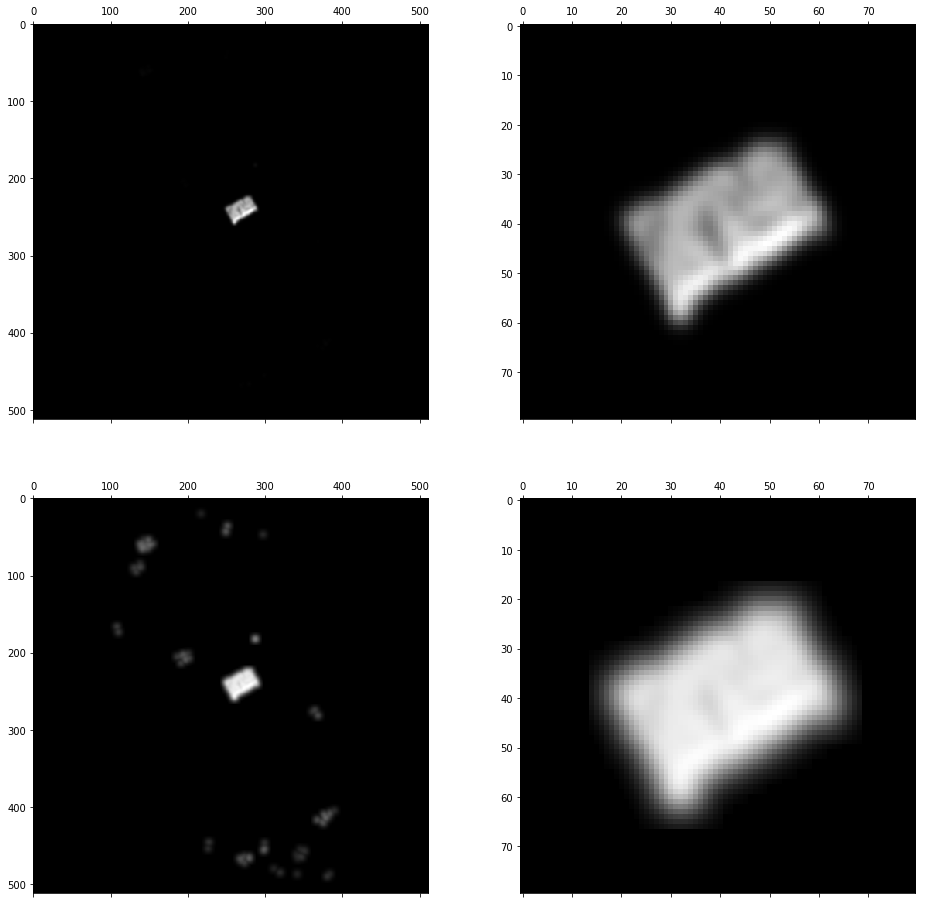

In [37]:
# Smooth average deconvolution

sigma_gaussianFilter2 = 2
average_deconvolution_gf = gaussian_filter(average_deconvolution, sigma_gaussianFilter2)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution_gf)
ax12.matshow(average_deconvolution_gf[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution_gf**0.25)
ax22.matshow(average_deconvolution_gf[x0-rad:x0+rad,y0-rad:y0+rad]**0.25)
plt.show()

In [38]:
# Get average central beam position, from CoM of average deconvolution

central_beam_qx0, central_beam_qy0 = py4DSTEM.process.utils.get_CoM(average_deconvolution)

In [39]:
# Get the average deconvolution

average_deconvolution = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list.data)):
    qx = int(Bragg_peak_point_list.data['qx'][i])
    qy = int(Bragg_peak_point_list.data['qy'][i])
    average_deconvolution[qx,qy] += Bragg_peak_point_list.data['intensity'][i]

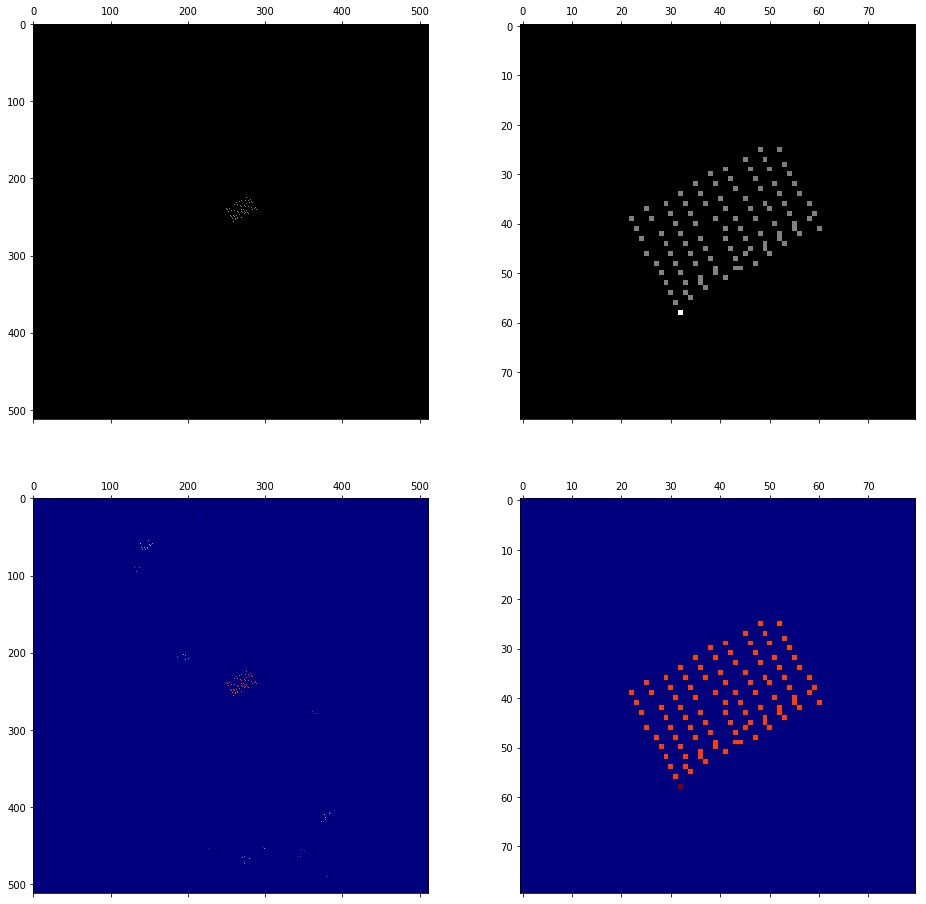

In [40]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution)
ax12.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution**0.25,cmap='jet')
ax22.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [41]:
# Get the diffraction shifts for each DP, using closest peak to CoM of average deconvolution

diffraction_shifts_intensity = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny)),
                                         parentDataCube=dc,slicelabels=('x','y'))
diffraction_shifts_position = RealSlice(data=np.empty((2,dc.R_Nx,dc.R_Ny))
                                        ,parentDataCube=dc,slicelabels=('x','y'))

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        index = np.argmax(Rij_point_list.data['intensity'])
        diffraction_shifts_intensity.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_intensity.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index = np.argmin(r2)
        diffraction_shifts_position.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index]
        diffraction_shifts_position.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index]

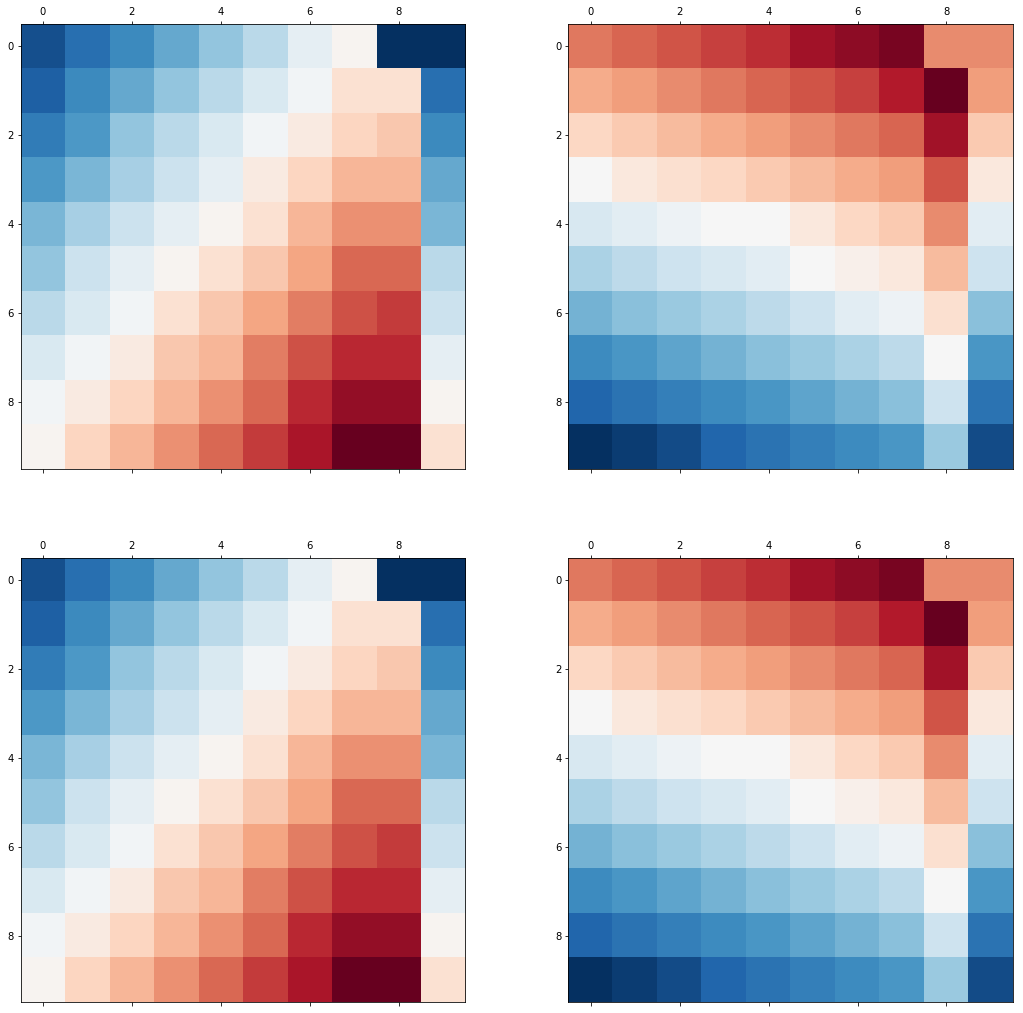

In [42]:
# Plot shifts

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(18,18))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax21.matshow(diffraction_shifts_intensity.data2D['x'],cmap="RdBu")
ax22.matshow(diffraction_shifts_intensity.data2D['y'],cmap="RdBu")
plt.show()

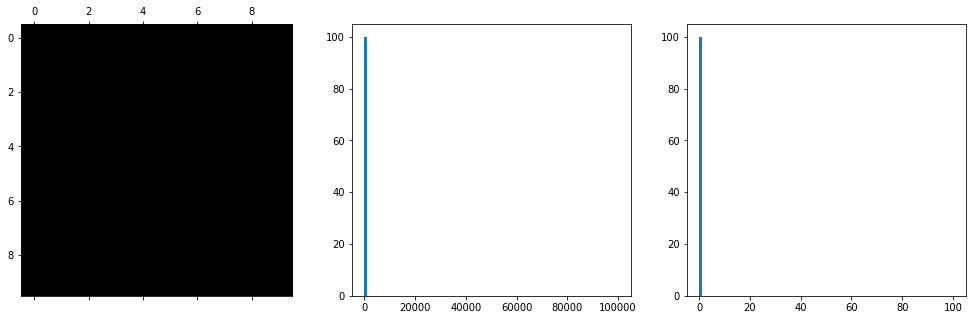

In [43]:
# Take distance between diffraction shifts detemined from positions and intensities

diff2 = (diffraction_shifts_intensity.data2D['x']-diffraction_shifts_position.data2D['x'])**2 + \
        (diffraction_shifts_intensity.data2D['y']-diffraction_shifts_position.data2D['y'])**2

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,5))
ax1.matshow(diff2)
ax2.hist(diff2.ravel(),bins=np.linspace(0,100000,100))
ax3.hist(diff2.ravel(),bins=np.linspace(0,100,100))
plt.show()

In [44]:
# Get the diffraction shifts for each DP
# Use only peaks where the peak (1) with highest intensity and (2) closest to CoM  are the same
# Mask off others

diffraction_shifts = RealSlice(data=np.zeros((3,dc.R_Nx,dc.R_Ny)),
                               parentDataCube=dc,slicelabels=('x','y','known_mask'))
diffraction_shifts.data2D['known_mask'] = diffraction_shifts.data2D['known_mask'].astype(bool)

for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        Rij_point_list = Bragg_peak_point_list.get_subpointlist([('rx',Ri),('ry',Rj)])
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index1 = np.argmin(r2)
        index2 = np.argmax(Rij_point_list.data['intensity'])
        
        if index1 == index2:
            diffraction_shifts.data2D['x'][Ri,Rj] = Rij_point_list.data['qx'][index1]
            diffraction_shifts.data2D['y'][Ri,Rj] = Rij_point_list.data['qy'][index1]
            diffraction_shifts.data2D['known_mask'][Ri,Rj] = True

In [45]:
# Subtract off average from diffraction shifts

diffraction_shifts.data2D['x']=diffraction_shifts.data2D['x']-np.average(diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']])
diffraction_shifts.data2D['y']=diffraction_shifts.data2D['y']-np.average(diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']])

diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']==False] = 0
diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']==False] = 0

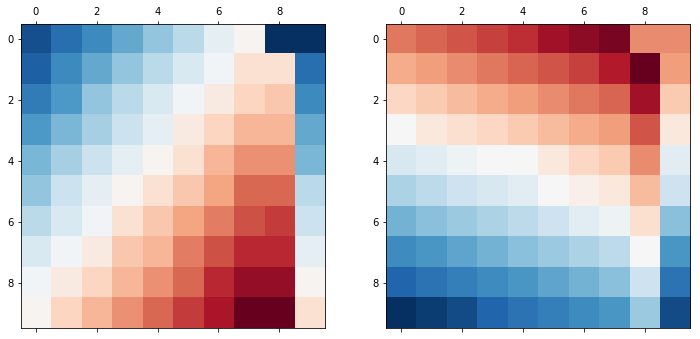

In [46]:
# Plot known shifts

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,18))
ax1.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax2.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
plt.show()

### 2c. Fit diffraction shifts

* Fit plane (or polynomial, or Bezier surface...) to unscattered beam positions

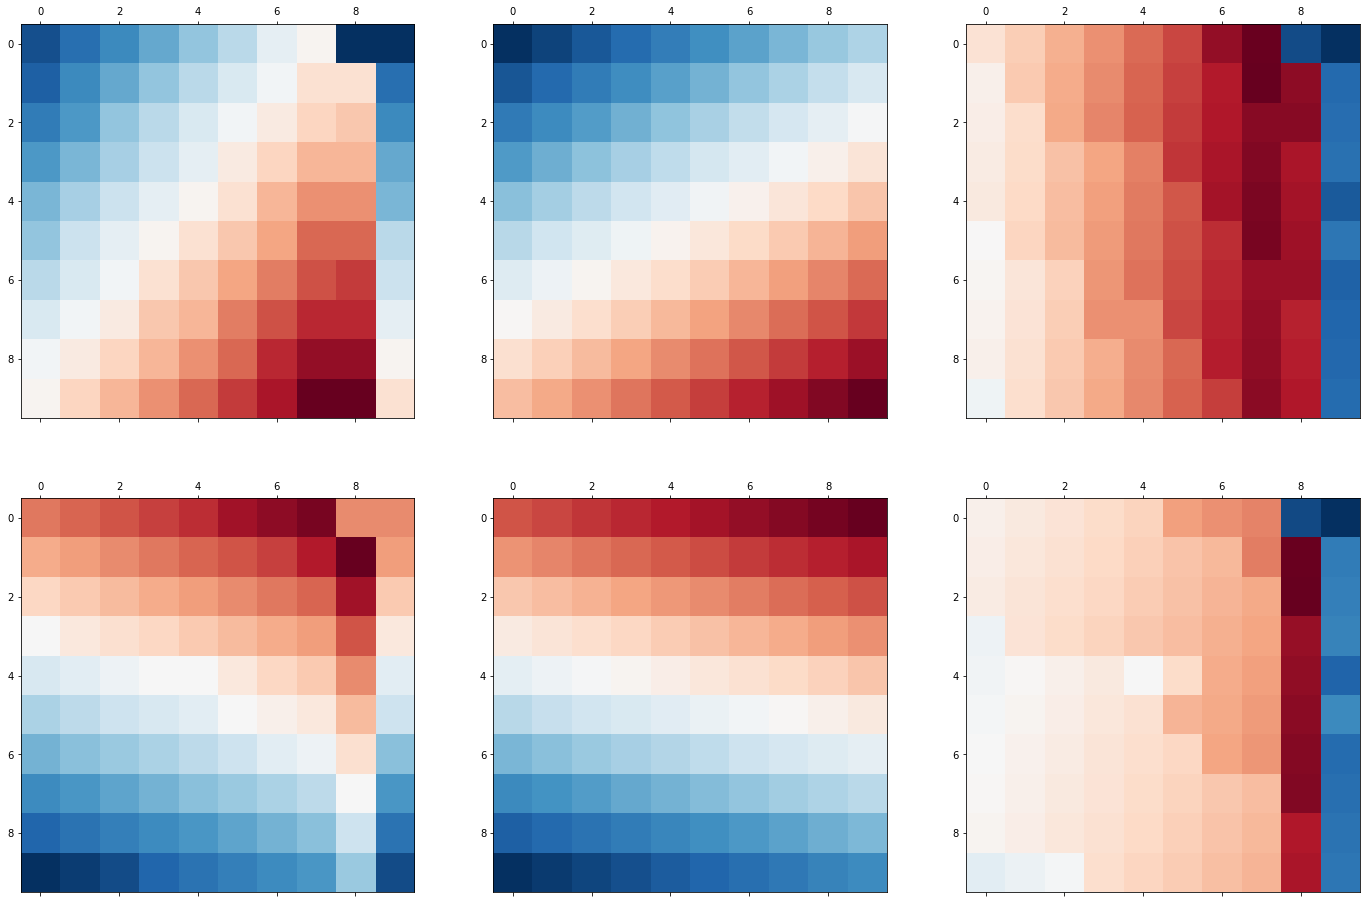

In [47]:
# Fit with all datapoints

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit_all = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                       parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit_all.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'])
popt_y, pcov_y, diffraction_shifts_fit_all.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'])

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax13.matshow(diffraction_shifts.data2D['x']-diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
ax23.matshow(diffraction_shifts.data2D['y']-diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
plt.show()

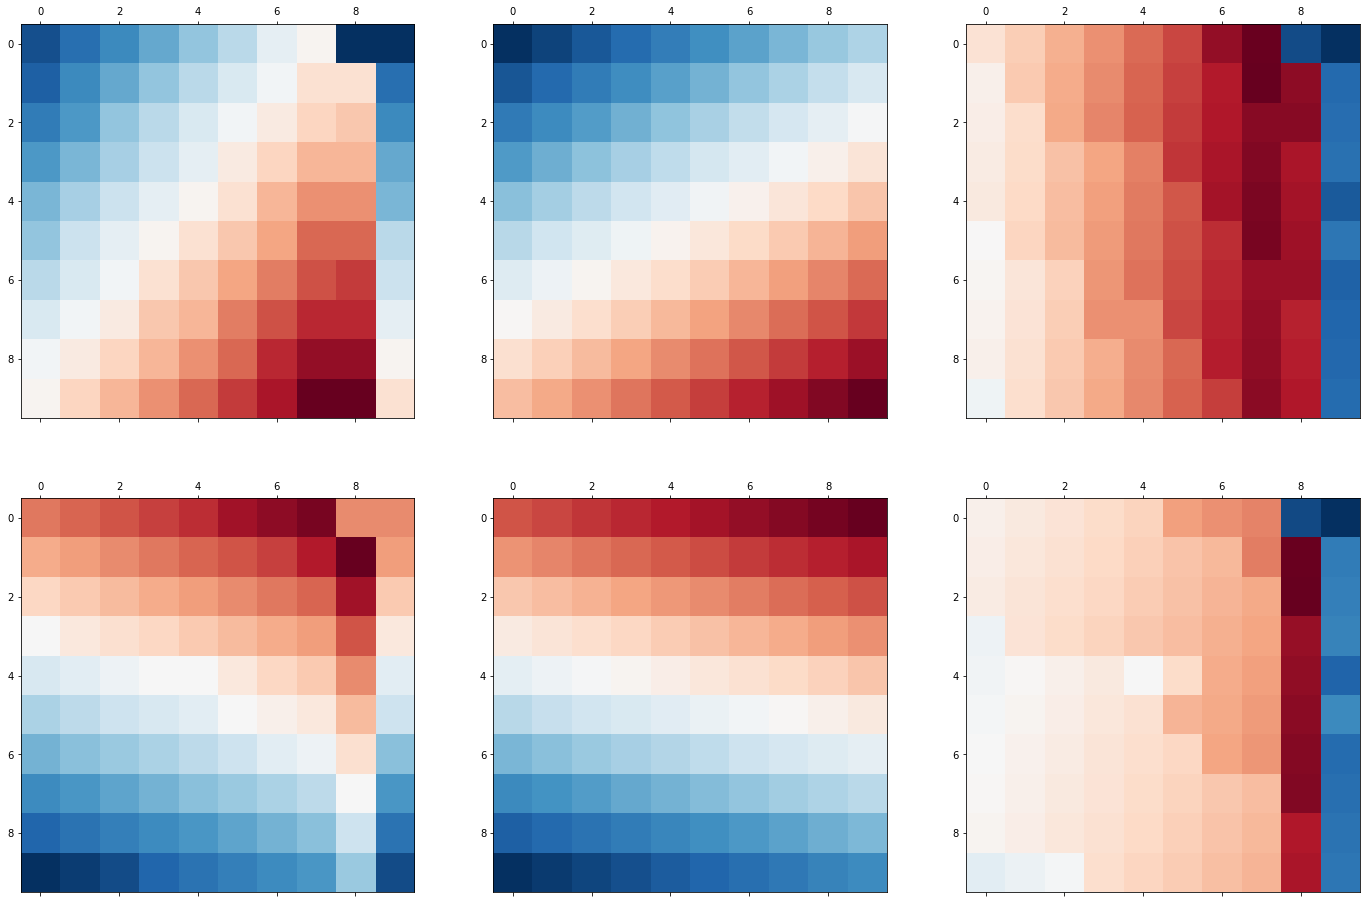

In [48]:
# Fit with only datapoints where diffraction_shifts_known==True

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit = RealSlice(data=np.zeros((2,dc.R_Nx,dc.R_Ny)),
                                    parentDataCube=dc,slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'], data_mask=diffraction_shifts.data2D['known_mask'])
popt_y, pcov_y, diffraction_shifts_fit.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'], data_mask=diffraction_shifts.data2D['known_mask'])

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax13.matshow(diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit.data2D['y'],cmap="RdBu")
ax23.matshow(diffraction_shifts.data2D['y']-diffraction_shifts_fit.data2D['y'],cmap="RdBu")
plt.show()

## 3. Correct the diffraction shifts

Finally, the diffraction pattern at each scan position is corrected for the calculated shifts.

* Datacube 
    * Apply shifts at each beam positions
    * Save new, processed datacube
* Averaged deconvolution
    * Apply shifts to recalculated averaged deconvolution

### 3a. Correct diffraction shifts in raw datacube

* Apply shifts at each beam positions
* Save new, processed datacube

In [49]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 1,0
Shifting DP from scan position 1,1
Shifting DP from scan position 1,2
Shifting DP from scan position 1,3
Shifting DP from scan position 1,4
Shifting DP from scan position 1,5
Shifting DP from scan position 1,6
Shifting DP from scan position 1,7
Shifting DP from scan position 1,8
Shifting DP from scan position 1,9
Shifting DP from scan position 2,0
Shifting DP from scan position 2,1
Shifting DP from scan position 2,2
Shifting DP from scan position 2,3
Shifting DP from scan position 2,4
Shifting DP from scan position 2,5
Shifting DP from scan position 2,6
Shifting DP from scan position 2,7
Shifting DP from sca

In [54]:
# Store new, shifted datacube
datacube_shifted = DataCube(data=data4D_corrected, parentDataCube=dc)

### 3b. Apply diffraction shifts to deconvolution

* Apply shifts to recalculated averaged deconvolution

In [55]:
# Get the shift corrected, average deconvolution

average_deconvolution_shiftcorrected = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list x)):
    rx = int(Bragg_peak_point_list['rx'][i])
    ry = int(Bragg_peak_point_list['ry'][i])
    shift_qx = int(diffraction_shifts_fit_x[rx,ry])
    shift_qy = int(diffraction_shifts_fit_y[rx,ry])
    qx = int(Bragg_peak_point_list['qx'][i]) - shift_qx
    qy = int(Bragg_peak_point_list['qy'][i]) - shift_qy

    average_deconvolution_shiftcorrected[qx,qy] += Bragg_peak_point_list['intensity'][i]

SyntaxError: invalid syntax (<ipython-input-55-494a4d1b6d62>, line 5)

In [36]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected)
x0,y0=int(x0),int(y0)
rad=80

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution_shiftcorrected)
ax12.matshow(average_deconvolution_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution_shiftcorrected**0.15,cmap='jet')
ax22.matshow(average_deconvolution_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

/Users/Ben/Work/NCEM/Projects/py4DSTEM/py4DSTEM-master/py4DSTEM/process/utils/utils.py:91: RuntimeWarning: invalid value encountered in double_scalars
  xCoM = np.sum(rx*ar)/tot_intens
/Users/Ben/Work/NCEM/Projects/py4DSTEM/py4DSTEM-master/py4DSTEM/process/utils/utils.py:92: RuntimeWarning: invalid value encountered in double_scalars
  yCoM = np.sum(ry*ar)/tot_intens


ValueError: cannot convert float NaN to integer

In [6]:
# Plot with gaussian blur

sigma = 2

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected)
x0,y0=int(x0),int(y0)
rad=80

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,16))
ax1.matshow(gaussian_filter(average_deconvolution_shiftcorrected,sigma)**0.15,cmap='jet')
ax2.matshow(gaussian_filter(average_deconvolution_shiftcorrected,sigma)[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

NameError: name 'average_deconvolution_shiftcorrected' is not defined

### 3c. Get deconvolutions from image subregions

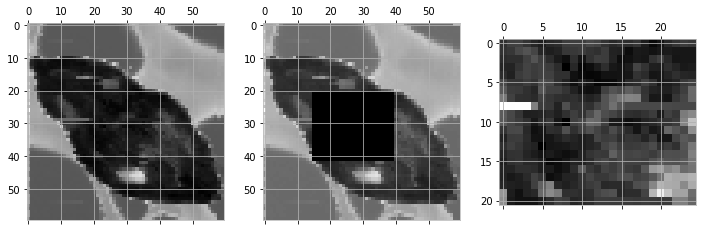

In [51]:
# Select ROI

xmin,xmax=21,42
ymin,ymax=15,40

im_ROI_sel = np.average(dc.data4D,axis=(2,3))
im_ROI_sel[xmin:xmax,ymin:ymax] = 0
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(im_ROI_sel,cmap='gray')
ax3.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

In [52]:
# Get deconvolution in ROI

average_deconvolution_shiftcorrected_ROI_1 = np.zeros((dc.Q_Ny,dc.Q_Nx))

for i in range(len(Bragg_peak_point_list)):
    rx = int(Bragg_peak_point_list['rx'][i])
    ry = int(Bragg_peak_point_list['ry'][i])
    if ((rx in range(xmin,xmax)) and (ry in range(ymin,ymax))):
        shift_qx = int(diffraction_shifts_fit_x[rx,ry])
        shift_qy = int(diffraction_shifts_fit_y[rx,ry])
        qx = int(Bragg_peak_point_list['qx'][i]) - shift_qx
        qy = int(Bragg_peak_point_list['qy'][i]) - shift_qy

        average_deconvolution_shiftcorrected_ROI_1[qx,qy] += Bragg_peak_point_list['intensity'][i]

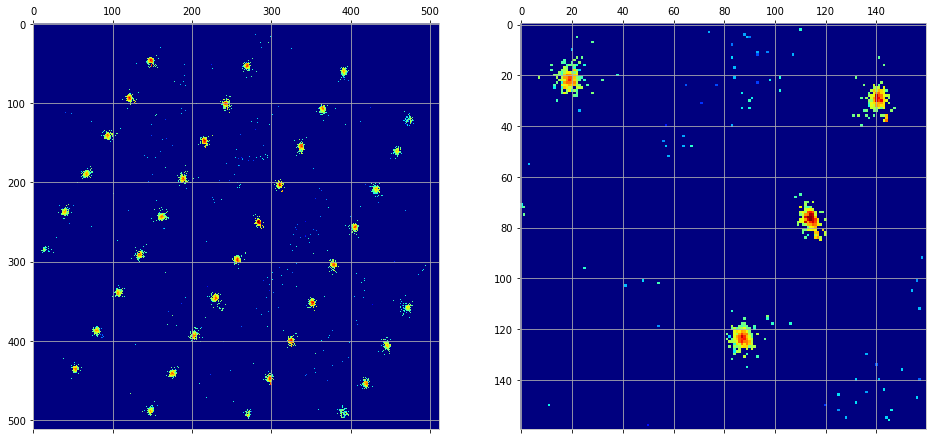

In [53]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution_shiftcorrected_ROI_1)
x0,y0=int(x0),int(y0)
rad=80

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,16))
ax1.matshow(average_deconvolution_shiftcorrected_ROI_1**0.15,cmap='jet')
ax2.matshow(average_deconvolution_shiftcorrected_ROI_1[x0-rad:x0+rad,y0-rad:y0+rad]**0.15,cmap='jet')
plt.show()

### Save

In [56]:
dc.dataobjecttracker.show_dataobjects()

 Index                  Name                        Type           Save   
   0                                        RawDataCube             Y     
   1                                        RealSlice               N     
   2                                        DiffractionSlice        N     
   3                                        DiffractionSlice        N     
   4                                        PointList               N     
   5                                        PointList               N     
   6                                        PointList               N     
   7                                        PointList               N     
   8                                        PointList               N     
   9                                        PointList               N     
   10                                       PointList               N     
   11                                       PointList               N     
   12                    

In [ ]:
# Save
fp="/home/ben/Desktop/example_shiftcorrection.h5"
py4DSTEM.readwrite.save(dc,fp)